In [122]:
import pandas as pd 

In [123]:
import numpy as np

In [124]:
!ls ../out

1_moreout.out  3_moreout.out  output_aCM.csv   output_SLATM.csv
2_moreout.out  4_moreout.out  output_FCHL.csv  output_SOAP.csv


In [125]:
slatm_out = pd.read_csv("../out/output_SLATM.csv", index_col=0)

In [126]:
slatm_out

,SolN,Fragments,Excess,ObjValNoPen,ObjValWithPen,Assignments
0,1,"['qm7_1107', 'qm7_5455']","[[6, 6], [6, 6]]",114778.0,154778.0,"[[(6, 4), (2, 5), (1, 6), (5, 9)], [(7, 1), (6..."
1,2,"['qm7_5455', 'qm7_1107']","[[6, 6], [6, 6]]",114778.0,154778.0,"[[(7, 1), (6, 2), (4, 3), (2, 7), (3, 8)], [(6..."
2,3,"['qm7_5455', 'qm7_1107']","[[6, 6], [6, 6]]",114778.0,154778.0,"[[(7, 1), (6, 2), (4, 3), (2, 7), (3, 8)], [(6..."
3,4,"['qm7_51', 'qm7_1112', 'qm7_111']","[[6], [6, 6], [6, 6, 7]]",94791.0,154791.0,"[[(2, 7), (3, 8), (4, 9)], [(1, 1), (2, 2), (6..."
4,5,"['qm7_51', 'qm7_1112', 'qm7_111']","[[6], [6, 6], [6, 6, 7]]",94791.0,154791.0,"[[(2, 7), (3, 8), (4, 9)], [(1, 1), (2, 2), (6..."
...,...,...,...,...,...,...
995,996,"['qm7_5544', 'qm7_47', 'qm7_111']","[[7, 6, 6], [6], [6, 6, 7]]",106335.0,176335.0,"[[(4, 2), (6, 3), (7, 4), (5, 6)], [(4, 7), (3..."
996,997,"['qm7_6084', 'qm7_6388']","[[8, 6, 6], [6, 6]]",126336.0,176336.0,"[[(6, 3), (7, 4), (2, 5), (1, 6)], [(5, 1), (4..."
997,998,"['qm7_6084', 'qm7_6388']","[[8, 6, 6], [6, 6]]",126336.0,176336.0,"[[(6, 3), (7, 4), (2, 5), (1, 6)], [(5, 1), (4..."
998,999,"['qm7_1112', 'qm7_5455']","[[6, 6], [6, 6]]",136353.0,176353.0,"[[(1, 1), (2, 2), (6, 3), (5, 4)], [(6, 5), (7..."


In [127]:
from ast import literal_eval 

In [128]:
slatm_out["Fragments"] = slatm_out["Fragments"].apply(literal_eval)

In [129]:
slatm_out["Sorted Fragments"] = slatm_out["Fragments"].apply(lambda x:sorted(x))

In [130]:
len(np.unique(slatm_out["Sorted Fragments"]))

223

In [184]:
# excess is missing Hs - to fix 

In [185]:
qm9_mol = qml.Compound("../targets/qm9_0.xyz")
qm9_ncharges = qm9_mol.nuclear_charges

In [186]:
qm9_ncharges

array([8, 6, 6, 7, 6, 8, 8, 7, 6, 1, 1])

In [189]:
def count_ncharges(list_ncharges, elements=[1,6,7,8,16]):
    ncharge_count = np.zeros(len(elements))
    for ncharge in list_ncharges:
        for i, elem in enumerate(elements):
            if ncharge == elem:
                ncharge_count[i] += 1
    return ncharge_count

In [190]:
qm9_counts = count_ncharges(qm9_ncharges)

In [191]:
qm9_counts

array([2., 4., 2., 3., 0.])

In [107]:
# get energies
# qm7 energies are in qm7 dir 
# need qm9 energies and excess contribution

In [145]:
from sklearn.linear_model import LinearRegression

In [146]:
# need ncharges list and list of energies

In [147]:
import qml

In [149]:
qm7 = pd.read_csv("../qm7/energies.csv", index_col=0)
files = qm7["file"].to_list()

In [150]:
mols = [qml.Compound("../qm7/xyz/"+x+".xyz") for x in files]

In [151]:
ncharges = [mol.nuclear_charges for mol in mols]

In [192]:
# ncharges convert to count
elements = [1, 6, 7, 8, 16]
ncharge_counts = []
for ncharge_list in ncharges: 
    ncharge_count = count_ncharges(ncharge_list)
    ncharge_counts.append(ncharge_count)

In [153]:
energies = qm7["energy / Ha"].to_list()

In [160]:
reg = LinearRegression().fit(ncharge_counts, energies)

In [161]:
reg.score(ncharge_counts, energies)

0.9999998316921461

In [163]:
coeff_energies = reg.coef_

In [164]:
coeff_energies

array([  -0.61002842,  -38.01906467,  -54.64773278,  -75.09076869,
       -397.94238855])

In [172]:
coeff_energies = dict(zip(elements, coeff_energies))

In [173]:
def match_file_to_energy(filename):
    energies = pd.read_csv("../qm7/energies.csv")
    energy = energies.loc[energies["file"] == filename]["energy / Ha"]
    return energy

In [174]:
def get_excess_energy(excess_ncharges):
    energy = np.sum([coeff_energies[x] for x in excess_ncharges])
    return energy

In [175]:
def get_reaction_energy(fragment_list, excess_ncharges):
    qm9_energy = -487.817450280942 # Ha
    
    all_excess_ncharges = np.concatenate(excess_ncharges)
    excess_energy = get_excess_energy(all_excess_ncharges)
    
    frag_energies = np.sum([match_file_to_energy(x) for x in fragment_list])
    
    rxn_energy = frag_energies - qm9_energy - excess_energy
    return rxn_energy

In [180]:
slatm_out["energies / Ha"] = slatm_out.apply(lambda x: get_reaction_energy(x["Fragments"], x["Excess"]), axis=1)

In [181]:
slatm_out["energies / kcal/mol"] = slatm_out["energies / Ha"] * 627.5

In [182]:
slatm_out

,SolN,Fragments,Excess,ObjValNoPen,ObjValWithPen,Assignments,Sorted Fragments,energies,energies / Ha,energies / kcal/mol
0,1,"[qm7_1107, qm7_5455]","[[6, 6], [6, 6]]",114778.0,154778.0,"[[(6, 4), (2, 5), (1, 6), (5, 9)], [(7, 1), (6...","[qm7_1107, qm7_5455]",-4.821831,-4.821831,-3025.698812
1,2,"[qm7_5455, qm7_1107]","[[6, 6], [6, 6]]",114778.0,154778.0,"[[(7, 1), (6, 2), (4, 3), (2, 7), (3, 8)], [(6...","[qm7_1107, qm7_5455]",-4.821831,-4.821831,-3025.698812
2,3,"[qm7_5455, qm7_1107]","[[6, 6], [6, 6]]",114778.0,154778.0,"[[(7, 1), (6, 2), (4, 3), (2, 7), (3, 8)], [(6...","[qm7_1107, qm7_5455]",-4.821831,-4.821831,-3025.698812
3,4,"[qm7_51, qm7_1112, qm7_111]","[[6], [6, 6], [6, 6, 7]]",94791.0,154791.0,"[[(2, 7), (3, 8), (4, 9)], [(1, 1), (2, 2), (6...","[qm7_111, qm7_1112, qm7_51]",-6.603790,-6.603790,-4143.878466
4,5,"[qm7_51, qm7_1112, qm7_111]","[[6], [6, 6], [6, 6, 7]]",94791.0,154791.0,"[[(2, 7), (3, 8), (4, 9)], [(1, 1), (2, 2), (6...","[qm7_111, qm7_1112, qm7_51]",-6.603790,-6.603790,-4143.878466
...,...,...,...,...,...,...,...,...,...,...
995,996,"[qm7_5544, qm7_47, qm7_111]","[[7, 6, 6], [6], [6, 6, 7]]",106335.0,176335.0,"[[(4, 2), (6, 3), (7, 4), (5, 6)], [(4, 7), (3...","[qm7_111, qm7_47, qm7_5544]",-7.263507,-7.263507,-4557.850406
996,997,"[qm7_6084, qm7_6388]","[[8, 6, 6], [6, 6]]",126336.0,176336.0,"[[(6, 3), (7, 4), (2, 5), (1, 6)], [(5, 1), (4...","[qm7_6084, qm7_6388]",-2.365496,-2.365496,-1484.348663
997,998,"[qm7_6084, qm7_6388]","[[8, 6, 6], [6, 6]]",126336.0,176336.0,"[[(6, 3), (7, 4), (2, 5), (1, 6)], [(5, 1), (4...","[qm7_6084, qm7_6388]",-2.365496,-2.365496,-1484.348663
998,999,"[qm7_1112, qm7_5455]","[[6, 6], [6, 6]]",136353.0,176353.0,"[[(1, 1), (2, 2), (6, 3), (5, 4)], [(6, 5), (7...","[qm7_1112, qm7_5455]",-4.808127,-4.808127,-3017.099479


In [178]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Reaction energy / kcal/mol')

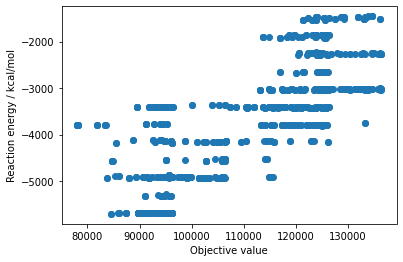

In [183]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(slatm_out["ObjValNoPen"], slatm_out["energies / kcal/mol"])
ax.set_xlabel("Objective value")
ax.set_ylabel("Reaction energy / kcal/mol")